In [16]:
%load_ext autoreload
%autoreload 2

import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import logging
import os
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import MCMC, NUTS, Predictive

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import pdb

def corrected_dawid_skene_model_with_observed(annotations, observed_z, mask):
    # print("observed_z", observed_z.shape)
    # print("observed_z", observed_z[:5])
    # print("mask", mask)
    # mask =   # Add a new dimension at the beginning
       
    # print("simulating...\r")
    num_items, num_raters = annotations.shape
    num_classes = len(torch.unique(annotations))
    # mask_repeated = mask.unsqueeze(0).repeat(num_raters, 1)
    # observed_z_repeated = observed_z.unsqueeze(0).repeat(num_raters, 1)  
    
    # Prior for the class proportions
    pi = pyro.sample("pi", dist.Dirichlet(torch.ones(num_classes)))

    # Priors for the annotator confusion matrices
    with pyro.plate("raters", num_raters):
        theta = pyro.sample("theta", dist.Dirichlet(0.5 * torch.eye(num_classes) + 0.25).to_event(1))


    with pyro.plate("items", num_items):
        
        # with pyro.poutine.mask(mask=mask):
        z = pyro.sample("z", dist.Categorical(pi), obs=observed_z, obs_mask=mask)
            # z = pyro.sample("z", dist.Categorical(pi))
        # z = pyro.sample("z", dist.Categorical(pi).mask(mask).to_event(1), obs=observed_z)
        pdb.set_trace()
        # print("observed_z", observed_z[:5])
        # print("z shape", z.shape)
        
        # Condition on the observed values using a mask
        # z = torch.where(mask, observed_z, z)
        
        for r in pyro.plate("raters_loop", num_raters):
            probs = theta[r, z, :]
            pyro.sample(f"y_{r}", dist.Categorical(probs), obs=annotations[:, r])

    # observed_annotations = annotations[mask]
    # unobserved_annotations = annotations[~mask]
    
    # observed_z_values = observed_z[mask]
    
    # # # For observed items
    # with pyro.plate("observed_items", observed_annotations.size(0)):
    #     # Condition on the observed z values
    #     z_observed = pyro.sample("z_observed", dist.Categorical(pi), obs=observed_z_values)
        
    #     for r in pyro.plate("raters_observed", num_raters):
    #         probs_observed = theta[r, z_observed, :]
    #         pyro.sample(f"y_observed_{r}", dist.Categorical(probs_observed), obs=observed_annotations[:, r])

    # # For unobserved items
    # with pyro.plate("unobserved_items", unobserved_annotations.size(0)):
    #     z_unobserved = pyro.sample("z_unobserved", dist.Categorical(pi))
        
    #     for r in pyro.plate("raters_unobserved", num_raters):
    #         probs_unobserved = theta[r, z_unobserved, :]
    #         pyro.sample(f"y_unobserved_{r}", dist.Categorical(probs_unobserved), obs=unobserved_annotations[:, r])

def simulate_data_with_observed(num_items, num_raters, true_pi, confusion_diagonal):
    num_classes = len(true_pi)
    
    # Create confusion matrix
    off_diag = (1 - confusion_diagonal) / (num_classes - 1)
    confusion_matrix = off_diag * torch.ones(num_classes, num_classes) + \
                       (confusion_diagonal - off_diag) * torch.eye(num_classes)
    
    # Simulate true labels
    z = dist.Categorical(true_pi).sample([num_items])
    
    # Create the observed_z tensor
    observed_z = torch.full((num_items,), -1, dtype=torch.int64)
    mask = torch.zeros(num_items, dtype=torch.bool)
    
    # Randomly select 10% of the items to reveal their true labels
    num_observed = int(0.5 * num_items)
    observed_indices = torch.randperm(num_items)[:num_observed]
    observed_z[observed_indices] = z[observed_indices]
    mask[observed_indices] = True
    
    # Simulate annotations based on true labels and confusion matrices
    annotations = torch.zeros((num_items, num_raters), dtype=torch.int64)
    for i in range(num_items):
        for r in range(num_raters):
            probs = confusion_matrix[:, z[i]]
            annotations[i, r] = dist.Categorical(probs).sample()
    
    return annotations, observed_z, mask
# dummy_annotations = torch.randint(0, 3, (100, 5))
# pyro.render_model(corrected_dawid_skene_model_with_observed, model_args=(dummy_annotations, dummy_annotations[:, 0], np.ones(1000)), render_params=True)


In [19]:
num_items = 1000
num_raters = 2
true_pi = torch.tensor([0.1, 0.3, 0.6])
confusion_diagonal = 0.9

annotations_simulated, observed_z, mask = simulate_data_with_observed(num_items, num_raters, true_pi, confusion_diagonal)
# Condition the model on the observed data
# old_mask = mask
mask[mask == True] = False 
observed_z[observed_z < 0] = 0
mask[0] = True
observed_z[0] = -1

# observed_z = observed_z.to(torch.float32)
# observed_z[observed_z < 0] = float('nan')

# conditioned_model = pyro.condition(corrected_dawid_skene_model_with_observed, data={"z": observed_z})
nuts_kernel = NUTS(corrected_dawid_skene_model_with_observed, jit_compile=True, ignore_jit_warnings=True)

# print(observed_z[mask == False])
# nuts_kernel = NUTS(conditioned_model, jit_compile=True, ignore_jit_warnings=True)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=500)
mcmc.run(annotations_simulated, observed_z, mask)

# # Extract posterior samples
# posterior_samples_corrected = mcmc.get_samples()

Warmup:   0%|          | 0/1500 [04:04, ?it/s]


sampling! None {} ()
sampling! None {} ()
sampling! tensor([ True, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        Fals

RuntimeError: index -1 is out of bounds for dimension 1 with size 3

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def simulate_models_and_predictions(num_models, N, num_features, external_N=10000):
    """
    Simulate models, get their predictions, and rank them based on accuracy on an external dataset.
    
    Parameters:
    - num_models: Number of models to simulate
    - N: Number of individuals in the training dataset
    - num_features: Number of features per individual
    - external_N: Number of individuals in the external dataset for accuracy estimation
    
    Returns:
    - Rankings of models based on accuracy on the external dataset
    - Matrix of class predictions for each model on the original dataset
    """
    
    # Generate the feature matrix X
    X = np.random.randn(N, num_features)
    
    # Generate the true beta coefficients
    beta = np.random.randn(num_features)
    
    # Generate the true y values using a Bernoulli distribution based on the sigmoid probabilities
    p = sigmoid(X @ beta)
    y = np.random.binomial(1, p)
    
    # Covariance matrix for beta'
    cov_matrix = np.full((num_features, num_features), 0.5)
    np.fill_diagonal(cov_matrix, 1)
    
    # Generate an external dataset X' for accuracy estimation
    X_prime = np.random.randn(external_N, num_features)
    p_values_prime = sigmoid(X_prime @ beta)
    y_prime = np.random.binomial(1, p_values_prime)
    
    # Matrix to store predictions from each model for both datasets
    predictions_on_N = np.zeros((N, num_models))
    accuracies = []
    
    for model_id in range(num_models):
        beta_prime = np.random.multivariate_normal(beta, cov_matrix)
        
        # Predictions on N
        y_hat_prob_N = sigmoid(X @ beta_prime)
        y_hat_N = np.random.binomial(1, y_hat_prob_N)
        predictions_on_N[:, model_id] = y_hat_N
        
        # Predictions and accuracy on external_N
        y_hat_prob_prime = sigmoid(X_prime @ beta_prime)
        y_hat_prime = np.random.binomial(1, y_hat_prob_prime)
        accuracy = np.mean(y_hat_prime == y_prime)
        accuracies.append((model_id, accuracy))
    
    # Rank models based on accuracy
    # ranked_models = sorted(accuracies, key=lambda x: x[1], reverse=True)
    
    return accuracies, predictions_on_N, y


rankings, predictions_on_N, true_y = simulate_models_and_predictions(num_models=5, N=1000, num_features=5)

# predictions_on_N


array([[1., 1., 1., 1., 1.],
       [0., 1., 0., 0., 1.],
       [0., 1., 0., 1., 1.],
       ...,
       [0., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1.],
       [1., 1., 1., 1., 0.]])

In [5]:
N=1000
indices = observed_indices = torch.randperm(N)[:5]
print(indices)

mask = [False for i in range(N)]
for index in indices:
    mask[index] = True


pyro.clear_param_store()
logging.getLogger("pyro").setLevel(logging.DEBUG)
nuts_kernel = NUTS(corrected_dawid_skene_model_with_observed, jit_compile=True, ignore_jit_warnings=True)
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=1500)

observed_y = torch.full((N,), -1, dtype=torch.int64)
observed_y[indices] = torch.tensor(true_y[indices])
mcmc.run(torch.tensor(predictions_on_N), observed_y, torch.tensor(mask))

posterior_samples_corrected = mcmc.get_samples()


tensor([611, 665, 669, 106,  95])


Warmup:   2%|▏         | 37/2000 [00:05, 16.94it/s, step size=4.61e-02, acc. prob=0.766]

KeyboardInterrupt: 

Warmup:  10%|▉         | 145/1500 [00:39, 20.65it/s, step size=1.99e-01, acc. prob=0.778]

In [4]:
# theta_mean = posterior_samples_corrected["theta"].mean(dim=0) 
# pi_mean = posterior_samples_corrected["pi"].mean(dim=0)

# result = pi_mean[0] * theta_mean[:, 0, 0] + pi_mean[1] * theta_mean[:, 1, 1]
# resulting_ranking = torch.argsort(result, descending=True)
# resulting_ranking.tolist()
# result
# posterior_samples_corrected["theta"].shape

In [5]:
pi_reshaped = posterior_samples_corrected["pi"].unsqueeze(1)

result = (pi_reshaped[:, :, 0] * posterior_samples_corrected["theta"][:, :, 0, 0] + 
          pi_reshaped[:, :, 1] * posterior_samples_corrected["theta"][:, :, 1, 1])

resulting_ranking = torch.argsort(result.mean(dim=0), descending=True)
print(result.mean(dim=0).tolist())
formatted_list = ["{:.3f}".format(item) for item in result.mean(dim=0).tolist()]
print(formatted_list)

NameError: name 'posterior_samples_corrected' is not defined

In [6]:
accs_only = [tup[1] for tup in rankings]
accs_only

[0.6724, 0.5668, 0.6522, 0.6039, 0.5811]

In [5]:
from scipy.stats import kendalltau
from scipy.stats import spearmanr

# Compute Kendall's tau using scipy's implementation
# spearmanr([0,1,2,3,4], [2,0,4,1,3])
spearmanr([1,0,2,4,3], [0,1,2,4,3])
# tau_scipy

# kendalltau(result.mean(dim=0).tolist(), accs_only)
# tau_scipy
# kendalltau([0,1,2,3,4], accs_only)

SignificanceResult(statistic=0.8999999999999998, pvalue=0.03738607346849874)

In [7]:
# rankings_only
from dawid_skene import run


import numpy as np

# Sample tensor
tensor = np.array([[1., 0., 0., 1., 1.],
                   [0., 0., 0., 0., 0.],
                   [0., 0., 1., 0., 0.],
                   # ... (For demonstration purposes, I've truncated the data.)
                   [0., 1., 1., 0., 0.],
                   [1., 1., 1., 1., 1.],
                   [1., 1., 1., 0., 0.]])

n_examples = predictions_on_N.shape[0]
n_classes = 2
n_models = predictions_on_N.shape[1]

one_hot_predictions = np.zeros((n_examples, n_models, n_classes))

# Loop over both classes
# Loop over both classes
for class_idx in range(n_classes):
    # Loop over each model (column)
    for i in range(n_models):
        one_class_preds = (predictions_on_N[:,i] == class_idx).astype(int)
        one_hot_predictions[np.arange(n_examples), i, class_idx] = one_class_preds


one_hot_predictions

array([[[0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.]],

       ...,

       [[1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.]],

       [[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]],

       [[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.]]])

In [8]:
# result
# _, _, _, _, blah, error_rates, _ = run(one_hot_predictions)



In [12]:
import importlib
import dawid_skene
importlib.reload(dawid_skene)
from dawid_skene import run

In [8]:
import pickle
# with open('kendalls_labeled.pkl', 'rb') as f:
#     kendalls_labeled = pickle.load(f)

# with open('spearmans_labeled.pkl', 'rb') as f:
#     spearmans_labeled = pickle.load(f)


# spearmans_labeled
# my_dict

In [9]:


# print(spearmans_labeled)
nsims = 25
# labels = [5, 10, 25, 50, 100]

# spearmans_unlabeled = []
# kendalls_unlabeled = []

labels = [10, 50, 100, 500]
# spearmans_labeled = {key: [] for key in labels}
# kendalls_labeled = {key: [] for key in labels}

# spearmans_labeled = [[] for i in range(len(labels))]
# kendalls_labeled = [[] for i in range(len(labels))]
i = 1

for sim in range(nsims):
    for i, label in enumerate(labels):
        print(label, sim)
        # label = 999
        rankings, predictions_on_N, true_y = simulate_models_and_predictions(num_models=5, N=1000, num_features=5)
        accs_only = [tup[1] for tup in rankings]

        match_rates = []
        for i in range(predictions_on_N.shape[1]):
            match_rate = np.mean(predictions_on_N[:, i] == true_y)
            match_rates.append(match_rate)

        N=1000
        indices = observed_indices = torch.randperm(N)[:label]
        # print(indices)

        mask = [False for i in range(N)]
        for index in indices:
            mask[index] = True


        pyro.clear_param_store()
        logging.getLogger("pyro").setLevel(logging.DEBUG)
        nuts_kernel = NUTS(corrected_dawid_skene_model_with_observed, jit_compile=True, ignore_jit_warnings=True)
        mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=500)

        observed_y = torch.full((N,), -1, dtype=torch.int64)
        observed_y[indices] = torch.tensor(true_y[indices])
        mcmc.run(torch.tensor(predictions_on_N), observed_y, torch.tensor(mask))

        posterior_samples_corrected = mcmc.get_samples()

        theta = posterior_samples_corrected["theta"]
        pi = posterior_samples_corrected["pi"]
        # 1. & 3. Take max values from rows 0 and 1 respectively
        max_row_0 = torch.max(theta[:,:,0,:], dim=2)[0]  # Shape: (500, 5)
        max_row_1 = torch.max(theta[:,:,1,:], dim=2)[0]  # Shape: (500, 5)

        # 2. & 4. Multiply with pi values
        result_row_0 = max_row_0 * pi[:,0].unsqueeze(1)  # Shape: (500, 5)
        result_row_1 = max_row_1 * pi[:,1].unsqueeze(1)  # Shape: (500, 5)

        # 5. Sum the results
        result = result_row_0 + result_row_1  # Shape: (500, 5)

        # result = final_result.mean(dim=0)

        
        # resulting_ranking = torch.argsort(result.mean(dim=0), descending=True)
        print(match_rates, result.mean(dim=0))

        sp_l = spearmanr(result.mean(dim=0), match_rates)[0]
        kend_l = kendalltau(result.mean(dim=0), match_rates)[0]
        print("Labeled: ", label, sp_l, kend_l)

        spearmans_labeled[label].append(sp_l)
        kendalls_labeled[label].append(kend_l)

        # n_examples = predictions_on_N.shape[0]
        # n_classes = 2
        # n_models = predictions_on_N.shape[1]

        # one_hot_predictions = np.zeros((n_examples, n_models, n_classes))

        # # Loop over both classes
        # # Loop over both classes
        # for class_idx in range(n_classes):
        #     # Loop over each model (column)
        #     for i in range(n_models):
        #         one_class_preds = (predictions_on_N[:,i] == class_idx).astype(int)
        #         one_hot_predictions[np.arange(n_examples), i, class_idx] = one_class_preds
            

        # _, _, _, _, prevalence, error_rates, _ = run(one_hot_predictions)
        # weighted_diagonal_sums = np.array([np.sum(matrix.diagonal() * prevalence)/2 for matrix in error_rates])
        # print(weighted_diagonal_sums, match_rates)
        # sp_u = spearmanr(weighted_diagonal_sums, match_rates)[0]
        # kend_u = kendalltau(weighted_diagonal_sums, match_rates)[0]
        # print("Unlabeled: ", sp_u, kend_u)
        # spearmans_unlabeled.append(sp_u)
        # kendalls_unlabeled.append(kend_u)


# with open('kendalls_unlabeled.pkl', 'wb') as f:
#     pickle.dump(kendalls_unlabeled, f)

        # with open('kendalls_labeled.pkl', 'wb') as f:
        #     pickle.dump(kendalls_labeled, f)

# with open('spearmans_unlabeled.pkl', 'wb') as f:
#     pickle.dump(spearmans_unlabeled, f)

        # with open('spearmans_labeled.pkl', 'wb') as f:
        #     pickle.dump(spearmans_labeled, f)






10 0


Warmup:   0%|          | 0/600 [00:00, ?it/s]

Sample: 100%|██████████| 600/600 [00:38, 15.45it/s, step size=5.69e-01, acc. prob=0.871]


[0.635, 0.698, 0.753, 0.66, 0.73] tensor([0.6578, 0.7836, 0.8934, 0.7230, 0.8496])
Labeled:  10 0.9999999999999999 0.9999999999999999
50 0


Sample: 100%|██████████| 600/600 [00:42, 14.21it/s, step size=4.63e-01, acc. prob=0.921]


[0.673, 0.507, 0.628, 0.507, 0.696] tensor([0.8442, 0.6013, 0.7263, 0.5725, 0.8217])
Labeled:  50 0.8720815992723809 0.7378647873726218
100 0


Sample: 100%|██████████| 600/600 [00:41, 14.44it/s, step size=5.12e-01, acc. prob=0.884]


[0.678, 0.674, 0.543, 0.733, 0.593] tensor([0.7345, 0.7555, 0.5299, 0.8695, 0.5799])
Labeled:  100 0.8999999999999998 0.7999999999999999
500 0


Sample: 100%|██████████| 600/600 [00:36, 16.23it/s, step size=6.13e-01, acc. prob=0.890]


[0.657, 0.61, 0.694, 0.656, 0.703] tensor([0.6884, 0.6433, 0.7476, 0.6655, 0.7250])
Labeled:  500 0.8999999999999998 0.7999999999999999
10 1


Sample: 100%|██████████| 600/600 [00:49, 12.20it/s, step size=4.54e-01, acc. prob=0.895]


[0.669, 0.615, 0.715, 0.644, 0.676] tensor([0.7028, 0.7396, 0.8699, 0.7259, 0.7491])
Labeled:  10 0.6 0.39999999999999997
50 1


Sample: 100%|██████████| 600/600 [00:46, 12.86it/s, step size=4.44e-01, acc. prob=0.905]


[0.632, 0.533, 0.597, 0.636, 0.567] tensor([0.7058, 0.5940, 0.7287, 0.7392, 0.6391])
Labeled:  50 0.8999999999999998 0.7999999999999999
100 1


Sample: 100%|██████████| 600/600 [00:42, 14.25it/s, step size=5.58e-01, acc. prob=0.905]


[0.68, 0.649, 0.782, 0.553, 0.651] tensor([0.8224, 0.8205, 0.7298, 0.5814, 0.7357])
Labeled:  100 0.3 0.19999999999999998
500 1


Sample: 100%|██████████| 600/600 [00:35, 16.76it/s, step size=6.27e-01, acc. prob=0.897]


[0.746, 0.712, 0.825, 0.639, 0.818] tensor([0.7964, 0.7469, 0.8384, 0.6614, 0.8534])
Labeled:  500 0.8999999999999998 0.7999999999999999
10 2


Sample: 100%|██████████| 600/600 [00:40, 14.91it/s, step size=5.43e-01, acc. prob=0.890]


[0.648, 0.727, 0.658, 0.689, 0.671] tensor([0.6239, 0.8959, 0.7710, 0.7164, 0.7897])
Labeled:  10 0.7 0.6
50 2


Sample: 100%|██████████| 600/600 [00:38, 15.43it/s, step size=5.15e-01, acc. prob=0.908]


[0.779, 0.744, 0.662, 0.79, 0.752] tensor([0.8432, 0.8248, 0.7130, 0.8550, 0.8572])
Labeled:  50 0.7 0.6
100 2


Sample: 100%|██████████| 600/600 [00:47, 12.57it/s, step size=5.23e-01, acc. prob=0.914]


[0.672, 0.645, 0.653, 0.598, 0.635] tensor([0.8543, 0.6763, 0.5721, 0.5303, 0.8034])
Labeled:  100 0.6 0.39999999999999997
500 2


Sample: 100%|██████████| 600/600 [00:41, 14.61it/s, step size=6.55e-01, acc. prob=0.900]


[0.766, 0.787, 0.758, 0.751, 0.541] tensor([0.8171, 0.8517, 0.7899, 0.7830, 0.5609])
Labeled:  500 0.9999999999999999 0.9999999999999999
10 3


Sample: 100%|██████████| 600/600 [00:43, 13.91it/s, step size=5.89e-01, acc. prob=0.892]


[0.535, 0.542, 0.577, 0.515, 0.539] tensor([0.7782, 0.7752, 0.8446, 0.9137, 0.6875])
Labeled:  10 -0.3 -0.19999999999999998
50 3


Sample: 100%|██████████| 600/600 [00:41, 14.29it/s, step size=5.89e-01, acc. prob=0.911]


[0.439, 0.436, 0.6, 0.625, 0.624] tensor([0.7810, 0.7418, 0.5684, 0.8926, 0.8142])
Labeled:  50 0.7 0.6
100 3


Sample: 100%|██████████| 600/600 [00:38, 15.55it/s, step size=7.00e-01, acc. prob=0.851]


[0.457, 0.57, 0.587, 0.622, 0.616] tensor([0.6426, 0.8013, 0.7545, 0.8351, 0.5972])
Labeled:  100 0.3 0.19999999999999998
500 3


Sample: 100%|██████████| 600/600 [00:36, 16.25it/s, step size=6.83e-01, acc. prob=0.879]


[0.655, 0.645, 0.583, 0.519, 0.693] tensor([0.7214, 0.7238, 0.6345, 0.5328, 0.7710])
Labeled:  500 0.8999999999999998 0.7999999999999999
10 4


Sample: 100%|██████████| 600/600 [00:40, 14.71it/s, step size=6.38e-01, acc. prob=0.832]


[0.684, 0.715, 0.671, 0.662, 0.698] tensor([0.7335, 0.8041, 0.8506, 0.6792, 0.8620])
Labeled:  10 0.49999999999999994 0.39999999999999997
50 4


Sample: 100%|██████████| 600/600 [00:38, 15.62it/s, step size=6.23e-01, acc. prob=0.854]


[0.72, 0.542, 0.585, 0.664, 0.707] tensor([0.8415, 0.5350, 0.5939, 0.7994, 0.8717])
Labeled:  50 0.8999999999999998 0.7999999999999999
100 4


Sample: 100%|██████████| 600/600 [00:40, 14.77it/s, step size=4.94e-01, acc. prob=0.913]


[0.588, 0.612, 0.622, 0.567, 0.642] tensor([0.6411, 0.8231, 0.7908, 0.7581, 0.6679])
Labeled:  100 0.09999999999999999 0.0
500 4


Sample: 100%|██████████| 600/600 [00:35, 17.00it/s, step size=6.36e-01, acc. prob=0.896]


[0.526, 0.734, 0.768, 0.754, 0.655] tensor([0.5204, 0.7825, 0.8394, 0.8168, 0.6583])
Labeled:  500 0.9999999999999999 0.9999999999999999
10 5


Sample: 100%|██████████| 600/600 [01:27,  6.83it/s, step size=2.04e-01, acc. prob=0.938]


[0.502, 0.453, 0.644, 0.5, 0.53] tensor([0.5269, 0.8854, 0.6513, 0.6726, 0.5200])
Labeled:  10 -0.7 -0.6
50 5


Sample: 100%|██████████| 600/600 [00:38, 15.62it/s, step size=5.86e-01, acc. prob=0.902]


[0.689, 0.771, 0.709, 0.699, 0.667] tensor([0.7892, 0.8328, 0.8002, 0.7516, 0.6091])
Labeled:  50 0.8999999999999998 0.7999999999999999
100 5


Sample: 100%|██████████| 600/600 [00:41, 14.58it/s, step size=5.13e-01, acc. prob=0.881]


[0.607, 0.579, 0.552, 0.605, 0.575] tensor([0.6509, 0.5384, 0.7750, 0.5200, 0.7815])
Labeled:  100 -0.6 -0.39999999999999997
500 5


Sample: 100%|██████████| 600/600 [00:36, 16.64it/s, step size=6.28e-01, acc. prob=0.877]


[0.758, 0.639, 0.743, 0.714, 0.77] tensor([0.7966, 0.6580, 0.7735, 0.7708, 0.8354])
Labeled:  500 0.9999999999999999 0.9999999999999999
10 6


Sample: 100%|██████████| 600/600 [02:00,  4.96it/s, step size=1.95e-01, acc. prob=0.430]


[0.568, 0.617, 0.636, 0.595, 0.539] tensor([0.5328, 0.8972, 0.6159, 0.6912, 0.5392])
Labeled:  10 0.6 0.39999999999999997
50 6


Sample: 100%|██████████| 600/600 [00:37, 16.13it/s, step size=5.88e-01, acc. prob=0.892]


[0.629, 0.632, 0.603, 0.643, 0.639] tensor([0.5394, 0.8268, 0.8309, 0.5770, 0.8338])
Labeled:  50 0.0 0.0
100 6


Sample: 100%|██████████| 600/600 [00:37, 15.82it/s, step size=6.89e-01, acc. prob=0.876]


[0.78, 0.763, 0.705, 0.759, 0.697] tensor([0.8145, 0.8227, 0.7082, 0.7693, 0.6505])
Labeled:  100 0.8999999999999998 0.7999999999999999
500 6


Sample: 100%|██████████| 600/600 [00:37, 15.91it/s, step size=5.89e-01, acc. prob=0.916]


[0.703, 0.712, 0.548, 0.676, 0.749] tensor([0.7115, 0.7821, 0.5301, 0.7354, 0.7884])
Labeled:  500 0.8999999999999998 0.7999999999999999
10 7


Sample: 100%|██████████| 600/600 [00:44, 13.40it/s, step size=4.58e-01, acc. prob=0.902]


[0.676, 0.677, 0.695, 0.714, 0.544] tensor([0.7996, 0.7413, 0.7390, 0.8575, 0.5372])
Labeled:  10 0.6 0.39999999999999997
50 7


Sample: 100%|██████████| 600/600 [00:40, 14.99it/s, step size=5.51e-01, acc. prob=0.869]


[0.735, 0.614, 0.673, 0.578, 0.634] tensor([0.7512, 0.8030, 0.5499, 0.5995, 0.7728])
Labeled:  50 -0.19999999999999998 -0.19999999999999998
100 7


Sample: 100%|██████████| 600/600 [00:40, 14.82it/s, step size=5.97e-01, acc. prob=0.910]


[0.667, 0.712, 0.726, 0.719, 0.757] tensor([0.6737, 0.6793, 0.8436, 0.8496, 0.8511])
Labeled:  100 0.8999999999999998 0.7999999999999999
500 7


Sample: 100%|██████████| 600/600 [00:40, 14.92it/s, step size=5.64e-01, acc. prob=0.910]


[0.586, 0.663, 0.634, 0.773, 0.643] tensor([0.5497, 0.7189, 0.6545, 0.7849, 0.6943])
Labeled:  500 0.9999999999999999 0.9999999999999999
10 8


Sample: 100%|██████████| 600/600 [00:42, 14.24it/s, step size=5.92e-01, acc. prob=0.878]


[0.682, 0.725, 0.66, 0.719, 0.685] tensor([0.7563, 0.8096, 0.8517, 0.8862, 0.6065])
Labeled:  10 0.09999999999999999 0.0
50 8


Sample: 100%|██████████| 600/600 [00:50, 11.93it/s, step size=4.01e-01, acc. prob=0.924]


[0.548, 0.497, 0.508, 0.633, 0.597] tensor([0.5291, 0.5891, 0.6729, 0.5869, 0.8911])
Labeled:  50 -0.09999999999999999 0.0
100 8


Sample: 100%|██████████| 600/600 [00:46, 12.78it/s, step size=5.72e-01, acc. prob=0.886]


[0.677, 0.644, 0.636, 0.67, 0.587] tensor([0.7262, 0.7846, 0.7859, 0.7662, 0.5467])
Labeled:  100 0.0 -0.19999999999999998
500 8


Sample: 100%|██████████| 600/600 [00:37, 15.90it/s, step size=6.60e-01, acc. prob=0.882]


[0.478, 0.657, 0.72, 0.604, 0.552] tensor([0.5260, 0.6867, 0.7455, 0.6484, 0.5930])
Labeled:  500 0.9999999999999999 0.9999999999999999
10 9


Sample: 100%|██████████| 600/600 [00:58, 10.32it/s, step size=3.66e-01, acc. prob=0.914]


[0.488, 0.475, 0.526, 0.532, 0.497] tensor([0.6876, 0.7875, 0.6715, 0.5496, 0.6933])
Labeled:  10 -0.8999999999999998 -0.7999999999999999
50 9


Sample: 100%|██████████| 600/600 [00:39, 15.14it/s, step size=5.38e-01, acc. prob=0.907]


[0.713, 0.787, 0.664, 0.761, 0.611] tensor([0.7570, 0.7594, 0.7431, 0.8096, 0.6310])
Labeled:  50 0.8999999999999998 0.7999999999999999
100 9


Sample: 100%|██████████| 600/600 [00:45, 13.17it/s, step size=5.17e-01, acc. prob=0.884]


[0.53, 0.571, 0.527, 0.558, 0.524] tensor([0.5527, 0.5607, 0.7124, 0.7023, 0.6814])
Labeled:  100 -0.3 -0.19999999999999998
500 9


Sample: 100%|██████████| 600/600 [00:37, 16.21it/s, step size=6.06e-01, acc. prob=0.884]


[0.674, 0.692, 0.697, 0.668, 0.645] tensor([0.6889, 0.7612, 0.7562, 0.7307, 0.7294])
Labeled:  500 0.6 0.39999999999999997
10 10


Sample: 100%|██████████| 600/600 [00:41, 14.57it/s, step size=5.32e-01, acc. prob=0.906]


[0.615, 0.592, 0.646, 0.623, 0.627] tensor([0.7935, 0.6545, 0.7277, 0.7773, 0.8539])
Labeled:  10 0.3 0.19999999999999998
50 10


Sample: 100%|██████████| 600/600 [00:42, 14.28it/s, step size=5.41e-01, acc. prob=0.885]


[0.549, 0.649, 0.623, 0.584, 0.679] tensor([0.6350, 0.7042, 0.6941, 0.6885, 0.8885])
Labeled:  50 0.9999999999999999 0.9999999999999999
100 10


Sample: 100%|██████████| 600/600 [00:38, 15.44it/s, step size=5.93e-01, acc. prob=0.898]


[0.639, 0.634, 0.5, 0.582, 0.419] tensor([0.6887, 0.7686, 0.6094, 0.6514, 0.7674])
Labeled:  100 0.19999999999999998 0.19999999999999998
500 10


Sample: 100%|██████████| 600/600 [00:36, 16.40it/s, step size=7.20e-01, acc. prob=0.862]


[0.71, 0.637, 0.625, 0.704, 0.7] tensor([0.7803, 0.7252, 0.6878, 0.6649, 0.7331])
Labeled:  500 0.39999999999999997 0.39999999999999997
10 11


Sample: 100%|██████████| 600/600 [00:46, 12.99it/s, step size=4.95e-01, acc. prob=0.880]


[0.576, 0.5, 0.493, 0.653, 0.728] tensor([0.8355, 0.7860, 0.7814, 0.5750, 0.5570])
Labeled:  10 -0.6 -0.39999999999999997
50 11


Sample: 100%|██████████| 600/600 [00:38, 15.76it/s, step size=6.38e-01, acc. prob=0.874]


[0.7, 0.673, 0.657, 0.625, 0.732] tensor([0.8048, 0.7024, 0.7201, 0.5941, 0.8318])
Labeled:  50 0.8999999999999998 0.7999999999999999
100 11


Sample: 100%|██████████| 600/600 [00:40, 14.97it/s, step size=6.07e-01, acc. prob=0.886]


[0.651, 0.687, 0.649, 0.625, 0.644] tensor([0.8233, 0.8647, 0.7719, 0.7637, 0.5846])
Labeled:  100 0.8999999999999998 0.7999999999999999
500 11


Sample: 100%|██████████| 600/600 [00:37, 15.81it/s, step size=7.12e-01, acc. prob=0.873]


[0.714, 0.672, 0.736, 0.702, 0.74] tensor([0.7859, 0.7472, 0.7701, 0.7221, 0.7341])
Labeled:  500 0.09999999999999999 0.0
10 12


Sample: 100%|██████████| 600/600 [00:38, 15.52it/s, step size=5.86e-01, acc. prob=0.873]


[0.725, 0.764, 0.715, 0.723, 0.683] tensor([0.8104, 0.8434, 0.8529, 0.6929, 0.7990])
Labeled:  10 0.19999999999999998 0.19999999999999998
50 12


Sample: 100%|██████████| 600/600 [00:39, 15.27it/s, step size=5.42e-01, acc. prob=0.897]


[0.618, 0.704, 0.71, 0.675, 0.659] tensor([0.5672, 0.8532, 0.8310, 0.7191, 0.7937])
Labeled:  50 0.7999999999999999 0.6
100 12


Sample: 100%|██████████| 600/600 [00:40, 14.86it/s, step size=7.22e-01, acc. prob=0.840]


[0.487, 0.603, 0.61, 0.565, 0.643] tensor([0.5212, 0.8032, 0.7539, 0.7783, 0.8460])
Labeled:  100 0.7 0.6
500 12


Sample: 100%|██████████| 600/600 [00:36, 16.27it/s, step size=6.55e-01, acc. prob=0.898]


[0.671, 0.55, 0.679, 0.554, 0.609] tensor([0.7162, 0.5396, 0.7452, 0.5375, 0.6612])
Labeled:  500 0.8999999999999998 0.7999999999999999
10 13


Sample: 100%|██████████| 600/600 [00:45, 13.07it/s, step size=5.11e-01, acc. prob=0.903]


[0.731, 0.64, 0.712, 0.635, 0.5] tensor([0.9044, 0.6750, 0.8358, 0.6718, 0.5181])
Labeled:  10 0.9999999999999999 0.9999999999999999
50 13


Sample: 100%|██████████| 600/600 [00:47, 12.68it/s, step size=6.07e-01, acc. prob=0.890]


[0.554, 0.419, 0.639, 0.648, 0.624] tensor([0.6428, 0.7317, 0.8756, 0.8194, 0.7754])
Labeled:  50 0.7999999999999999 0.6
100 13


Sample: 100%|██████████| 600/600 [00:42, 14.02it/s, step size=5.12e-01, acc. prob=0.907]


[0.705, 0.669, 0.633, 0.651, 0.652] tensor([0.7448, 0.6992, 0.6274, 0.6639, 0.6817])
Labeled:  100 0.9999999999999999 0.9999999999999999
500 13


Sample: 100%|██████████| 600/600 [00:39, 15.32it/s, step size=6.57e-01, acc. prob=0.907]


[0.784, 0.797, 0.678, 0.743, 0.8] tensor([0.8164, 0.8405, 0.7252, 0.8069, 0.8618])
Labeled:  500 0.9999999999999999 0.9999999999999999
10 14


Sample: 100%|██████████| 600/600 [01:05,  9.20it/s, step size=3.40e-01, acc. prob=0.899]


[0.643, 0.582, 0.549, 0.628, 0.598] tensor([0.8365, 0.6024, 0.6212, 0.5222, 0.8067])
Labeled:  10 0.3 0.19999999999999998
50 14


Sample: 100%|██████████| 600/600 [00:40, 14.87it/s, step size=4.94e-01, acc. prob=0.914]


[0.692, 0.657, 0.704, 0.63, 0.695] tensor([0.7365, 0.6965, 0.7517, 0.6616, 0.7676])
Labeled:  50 0.8999999999999998 0.7999999999999999
100 14


Sample: 100%|██████████| 600/600 [00:38, 15.67it/s, step size=6.18e-01, acc. prob=0.896]


[0.743, 0.734, 0.765, 0.776, 0.73] tensor([0.8295, 0.8411, 0.6716, 0.7445, 0.8364])
Labeled:  100 -0.7999999999999999 -0.6
500 14


Sample: 100%|██████████| 600/600 [00:35, 16.95it/s, step size=6.96e-01, acc. prob=0.867]


[0.594, 0.614, 0.661, 0.565, 0.577] tensor([0.6109, 0.7212, 0.7620, 0.6649, 0.6297])
Labeled:  500 0.6 0.39999999999999997
10 15


Sample: 100%|██████████| 600/600 [00:51, 11.60it/s, step size=4.15e-01, acc. prob=0.900]


[0.596, 0.642, 0.698, 0.601, 0.555] tensor([0.5862, 0.8346, 0.8599, 0.5262, 0.7074])
Labeled:  10 0.6 0.39999999999999997
50 15


Sample: 100%|██████████| 600/600 [00:38, 15.52it/s, step size=5.73e-01, acc. prob=0.869]


[0.571, 0.739, 0.601, 0.686, 0.694] tensor([0.6751, 0.7955, 0.6469, 0.8210, 0.8288])
Labeled:  50 0.6 0.39999999999999997
100 15


Sample: 100%|██████████| 600/600 [00:38, 15.70it/s, step size=6.19e-01, acc. prob=0.868]


[0.72, 0.773, 0.742, 0.702, 0.723] tensor([0.7207, 0.8816, 0.8326, 0.7522, 0.7873])
Labeled:  100 0.8999999999999998 0.7999999999999999
500 15


Sample: 100%|██████████| 600/600 [00:36, 16.52it/s, step size=6.64e-01, acc. prob=0.865]


[0.637, 0.537, 0.775, 0.693, 0.699] tensor([0.6260, 0.5317, 0.8043, 0.7229, 0.7499])
Labeled:  500 0.9999999999999999 0.9999999999999999
10 16


Sample: 100%|██████████| 600/600 [00:50, 11.94it/s, step size=5.02e-01, acc. prob=0.864]


[0.617, 0.681, 0.623, 0.603, 0.624] tensor([0.6851, 0.8432, 0.7537, 0.7242, 0.7474])
Labeled:  10 0.7999999999999999 0.6
50 16


Sample: 100%|██████████| 600/600 [00:41, 14.50it/s, step size=5.36e-01, acc. prob=0.882]


[0.594, 0.714, 0.613, 0.654, 0.786] tensor([0.7336, 0.8372, 0.5942, 0.7598, 0.7354])
Labeled:  50 0.6 0.39999999999999997
100 16


Sample: 100%|██████████| 600/600 [00:38, 15.65it/s, step size=5.50e-01, acc. prob=0.915]


[0.704, 0.714, 0.687, 0.703, 0.586] tensor([0.7284, 0.7787, 0.7824, 0.7887, 0.5413])
Labeled:  100 0.19999999999999998 0.19999999999999998
500 16


Sample: 100%|██████████| 600/600 [00:36, 16.60it/s, step size=6.11e-01, acc. prob=0.907]


[0.587, 0.712, 0.673, 0.675, 0.733] tensor([0.6316, 0.7577, 0.7254, 0.7392, 0.7489])
Labeled:  500 0.8999999999999998 0.7999999999999999
10 17


Sample: 100%|██████████| 600/600 [01:15,  7.94it/s, step size=2.54e-01, acc. prob=0.921]


[0.588, 0.495, 0.579, 0.604, 0.542] tensor([0.8142, 0.5560, 0.5709, 0.5814, 0.7210])
Labeled:  10 0.49999999999999994 0.39999999999999997
50 17


Sample: 100%|██████████| 600/600 [00:40, 14.76it/s, step size=6.26e-01, acc. prob=0.886]


[0.742, 0.692, 0.645, 0.726, 0.732] tensor([0.8404, 0.7724, 0.6936, 0.7464, 0.7701])
Labeled:  50 0.7 0.6
100 17


Sample: 100%|██████████| 600/600 [00:43, 13.77it/s, step size=4.70e-01, acc. prob=0.909]


[0.533, 0.647, 0.596, 0.643, 0.649] tensor([0.6126, 0.7538, 0.7165, 0.6963, 0.7176])
Labeled:  100 0.7999999999999999 0.6
500 17


Sample: 100%|██████████| 600/600 [00:37, 15.99it/s, step size=6.38e-01, acc. prob=0.893]


[0.652, 0.692, 0.716, 0.734, 0.727] tensor([0.6454, 0.7282, 0.7508, 0.7778, 0.7432])
Labeled:  500 0.8999999999999998 0.7999999999999999
10 18


Sample: 100%|██████████| 600/600 [00:44, 13.62it/s, step size=4.73e-01, acc. prob=0.920]


[0.544, 0.618, 0.526, 0.638, 0.402] tensor([0.6871, 0.8287, 0.6139, 0.8164, 0.7887])
Labeled:  10 0.6 0.39999999999999997
50 18


Sample: 100%|██████████| 600/600 [00:43, 13.73it/s, step size=5.66e-01, acc. prob=0.867]


[0.549, 0.537, 0.668, 0.703, 0.612] tensor([0.5306, 0.5838, 0.8558, 0.8543, 0.7201])
Labeled:  50 0.7999999999999999 0.6
100 18


Sample: 100%|██████████| 600/600 [00:38, 15.64it/s, step size=6.24e-01, acc. prob=0.905]


[0.73, 0.707, 0.712, 0.633, 0.683] tensor([0.7562, 0.7819, 0.7884, 0.5862, 0.7211])
Labeled:  100 0.7 0.6
500 18


Sample: 100%|██████████| 600/600 [00:46, 12.77it/s, step size=6.10e-01, acc. prob=0.897]


[0.573, 0.575, 0.627, 0.516, 0.603] tensor([0.5995, 0.5797, 0.6216, 0.5285, 0.6168])
Labeled:  500 0.8999999999999998 0.7999999999999999
10 19


Sample: 100%|██████████| 600/600 [00:41, 14.63it/s, step size=5.89e-01, acc. prob=0.891]


[0.76, 0.72, 0.757, 0.731, 0.776] tensor([0.7352, 0.8000, 0.8666, 0.8045, 0.8358])
Labeled:  10 0.19999999999999998 0.19999999999999998
50 19


Sample: 100%|██████████| 600/600 [00:44, 13.37it/s, step size=5.85e-01, acc. prob=0.877]


[0.697, 0.633, 0.688, 0.637, 0.666] tensor([0.7272, 0.6402, 0.8470, 0.7009, 0.8161])
Labeled:  50 0.7 0.6
100 19


Sample: 100%|██████████| 600/600 [00:46, 12.95it/s, step size=5.83e-01, acc. prob=0.903]


[0.64, 0.689, 0.753, 0.748, 0.667] tensor([0.7587, 0.8051, 0.6844, 0.8661, 0.7900])
Labeled:  100 0.0 0.19999999999999998
500 19


Sample: 100%|██████████| 600/600 [00:41, 14.51it/s, step size=6.07e-01, acc. prob=0.907]


[0.625, 0.658, 0.618, 0.581, 0.589] tensor([0.6499, 0.6557, 0.6392, 0.5859, 0.6043])
Labeled:  500 0.9999999999999999 0.9999999999999999
10 20


Sample: 100%|██████████| 600/600 [00:51, 11.72it/s, step size=4.63e-01, acc. prob=0.870]


[0.617, 0.638, 0.666, 0.675, 0.633] tensor([0.7131, 0.7009, 0.8070, 0.7341, 0.7329])
Labeled:  10 0.6 0.39999999999999997
50 20


Sample: 100%|██████████| 600/600 [00:40, 14.95it/s, step size=5.74e-01, acc. prob=0.860]


[0.615, 0.71, 0.695, 0.668, 0.598] tensor([0.7778, 0.6660, 0.7085, 0.7537, 0.7462])
Labeled:  50 -0.7 -0.6
100 20


Sample: 100%|██████████| 600/600 [00:42, 13.98it/s, step size=6.05e-01, acc. prob=0.893]


[0.623, 0.608, 0.575, 0.625, 0.602] tensor([0.8000, 0.5820, 0.5229, 0.6248, 0.8600])
Labeled:  100 0.3 0.19999999999999998
500 20


Sample: 100%|██████████| 600/600 [00:36, 16.27it/s, step size=5.82e-01, acc. prob=0.907]


[0.686, 0.578, 0.494, 0.688, 0.559] tensor([0.7500, 0.5896, 0.5227, 0.7460, 0.5510])
Labeled:  500 0.8999999999999998 0.7999999999999999
10 21


Sample: 100%|██████████| 600/600 [00:58, 10.32it/s, step size=3.39e-01, acc. prob=0.928]


[0.573, 0.574, 0.6, 0.583, 0.54] tensor([0.6547, 0.6319, 0.5633, 0.8947, 0.5502])
Labeled:  10 0.3 0.19999999999999998
50 21


Sample: 100%|██████████| 600/600 [00:42, 14.26it/s, step size=4.79e-01, acc. prob=0.911]


[0.444, 0.463, 0.539, 0.61, 0.598] tensor([0.6814, 0.5854, 0.8233, 0.6258, 0.7097])
Labeled:  50 0.09999999999999999 0.0
100 21


Sample: 100%|██████████| 600/600 [00:39, 15.32it/s, step size=6.64e-01, acc. prob=0.872]


[0.721, 0.681, 0.714, 0.7, 0.636] tensor([0.7598, 0.7616, 0.6496, 0.7992, 0.5613])
Labeled:  100 0.19999999999999998 0.19999999999999998
500 21


Sample: 100%|██████████| 600/600 [00:37, 15.97it/s, step size=6.82e-01, acc. prob=0.867]


[0.772, 0.705, 0.777, 0.711, 0.658] tensor([0.7765, 0.7329, 0.8207, 0.7910, 0.7247])
Labeled:  500 0.8999999999999998 0.7999999999999999
10 22


Sample: 100%|██████████| 600/600 [00:43, 13.90it/s, step size=4.83e-01, acc. prob=0.892]


[0.583, 0.61, 0.689, 0.648, 0.471] tensor([0.5618, 0.8811, 0.8378, 0.7709, 0.7872])
Labeled:  10 0.3 0.19999999999999998
50 22


Sample: 100%|██████████| 600/600 [00:41, 14.53it/s, step size=5.78e-01, acc. prob=0.904]


[0.738, 0.697, 0.6, 0.701, 0.69] tensor([0.8656, 0.6830, 0.5348, 0.8316, 0.7177])
Labeled:  50 0.8999999999999998 0.7999999999999999
100 22


Sample: 100%|██████████| 600/600 [00:38, 15.76it/s, step size=6.26e-01, acc. prob=0.875]


[0.697, 0.669, 0.703, 0.708, 0.713] tensor([0.8199, 0.6606, 0.7697, 0.6999, 0.8704])
Labeled:  100 0.6 0.39999999999999997
500 22


Sample: 100%|██████████| 600/600 [00:35, 16.98it/s, step size=5.91e-01, acc. prob=0.928]


[0.612, 0.675, 0.642, 0.68, 0.662] tensor([0.6354, 0.7095, 0.6793, 0.7434, 0.6919])
Labeled:  500 0.9999999999999999 0.9999999999999999
10 23


Sample: 100%|██████████| 600/600 [00:48, 12.45it/s, step size=2.56e-01, acc. prob=0.856]


[0.698, 0.711, 0.676, 0.749, 0.708] tensor([0.7279, 0.7223, 0.6694, 0.8943, 0.7277])
Labeled:  10 0.6 0.39999999999999997
50 23


Sample: 100%|██████████| 600/600 [00:40, 14.92it/s, step size=5.89e-01, acc. prob=0.896]


[0.671, 0.607, 0.695, 0.675, 0.668] tensor([0.7952, 0.5557, 0.8212, 0.7523, 0.6954])
Labeled:  50 0.8999999999999998 0.7999999999999999
100 23


Sample: 100%|██████████| 600/600 [00:37, 16.05it/s, step size=6.03e-01, acc. prob=0.911]


[0.766, 0.757, 0.741, 0.732, 0.669] tensor([0.7039, 0.6880, 0.7795, 0.8029, 0.7360])
Labeled:  100 -0.6 -0.39999999999999997
500 23


Sample: 100%|██████████| 600/600 [00:36, 16.55it/s, step size=6.55e-01, acc. prob=0.881]


[0.719, 0.703, 0.682, 0.708, 0.658] tensor([0.7258, 0.7791, 0.7584, 0.7716, 0.7233])
Labeled:  500 0.3 0.19999999999999998
10 24


Sample: 100%|██████████| 600/600 [00:46, 12.97it/s, step size=5.20e-01, acc. prob=0.842]


[0.59, 0.649, 0.611, 0.641, 0.596] tensor([0.5497, 0.7986, 0.7416, 0.8612, 0.6653])
Labeled:  10 0.8999999999999998 0.7999999999999999
50 24


Sample: 100%|██████████| 600/600 [00:47, 12.71it/s, step size=5.80e-01, acc. prob=0.889]


[0.547, 0.674, 0.631, 0.712, 0.659] tensor([0.5218, 0.8227, 0.7827, 0.8425, 0.7988])
Labeled:  50 0.9999999999999999 0.9999999999999999
100 24


Sample: 100%|██████████| 600/600 [00:44, 13.59it/s, step size=5.23e-01, acc. prob=0.893]


[0.606, 0.625, 0.528, 0.539, 0.629] tensor([0.8169, 0.5597, 0.7232, 0.5597, 0.7022])
Labeled:  100 -0.09999999999999999 0.0
500 24


Sample: 100%|██████████| 600/600 [00:38, 15.44it/s, step size=6.78e-01, acc. prob=0.884]

[0.701, 0.739, 0.691, 0.737, 0.718] tensor([0.7488, 0.7666, 0.7385, 0.7730, 0.7653])
Labeled:  500 0.8999999999999998 0.7999999999999999


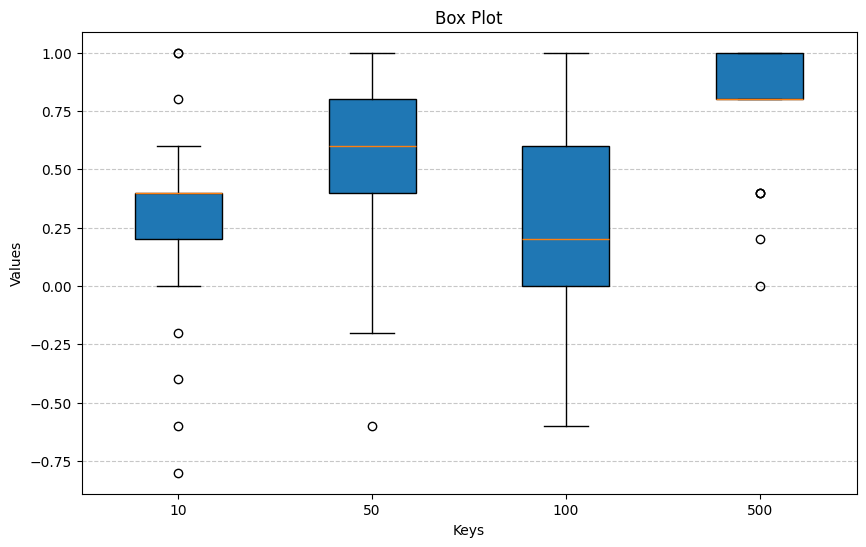

In [10]:
labels = [key for key in kendalls_labeled.keys()]
values = list(kendalls_labeled.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.boxplot(values, vert=True, patch_artist=True, labels=labels)
plt.title("Box Plot")
plt.xlabel("Keys")
plt.ylabel("Values")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [13]:
kend_us = []
for sim in range(100):

    rankings, predictions_on_N, true_y = simulate_models_and_predictions(num_models=5, N=1000, num_features=5)
    accs_only = [tup[1] for tup in rankings]

    match_rates = []
    for i in range(predictions_on_N.shape[1]):
        match_rate = np.mean(predictions_on_N[:, i] == true_y)
        match_rates.append(match_rate)


    n_examples = predictions_on_N.shape[0]
    n_classes = 2
    n_models = predictions_on_N.shape[1]

    one_hot_predictions = np.zeros((n_examples, n_models, n_classes))

    # Loop over both classes
    # Loop over both classes
    for class_idx in range(n_classes):
        # Loop over each model (column)
        for i in range(n_models):
            one_class_preds = (predictions_on_N[:,i] == class_idx).astype(int)
            one_hot_predictions[np.arange(n_examples), i, class_idx] = one_class_preds
        

    _, _, _, _, prevalence, error_rates, _ = run(one_hot_predictions)
    weighted_diagonal_sums = np.array([np.sum(matrix.diagonal() * prevalence)/2 for matrix in error_rates])
    print(weighted_diagonal_sums, match_rates)
    sp_u = spearmanr(weighted_diagonal_sums, match_rates)[0]
    kend_u = kendalltau(weighted_diagonal_sums, match_rates)[0]
    kend_us.append(kend_u)

# kend_u

[0.4204 0.4566 0.3873 0.4539 0.4199] [0.783, 0.805, 0.709, 0.815, 0.763]
[0.449  0.2849 0.345  0.3642 0.4091] [0.691, 0.635, 0.633, 0.658, 0.671]
[0.3519 0.3611 0.3862 0.4051 0.4316] [0.663, 0.648, 0.7, 0.708, 0.736]
[0.2797 0.4676 0.2816 0.4022 0.389 ] [0.637, 0.663, 0.619, 0.6, 0.666]
[0.4417 0.3543 0.4123 0.396  0.3871] [0.751, 0.649, 0.743, 0.746, 0.733]
[0.4189 0.3335 0.3009 0.3627 0.3673] [0.622, 0.689, 0.665, 0.556, 0.573]
[0.1163 0.2584 0.4072 0.4744 0.2823] [0.421, 0.572, 0.676, 0.671, 0.639]
[0.3726 0.2962 0.4987 0.2607 0.2451] [0.659, 0.653, 0.675, 0.555, 0.631]
[0.3661 0.4243 0.348  0.3541 0.326 ] [0.666, 0.69, 0.64, 0.629, 0.609]
[0.3659 0.3202 0.3823 0.3959 0.4294] [0.681, 0.712, 0.636, 0.653, 0.68]
[0.3133 0.4284 0.2814 0.3468 0.4675] [0.626, 0.747, 0.537, 0.666, 0.779]
[0.4156 0.4163 0.4186 0.3011 0.2366] [0.66, 0.649, 0.694, 0.579, 0.563]
[0.2708 0.4389 0.3562 0.2283 0.3367] [0.597, 0.643, 0.623, 0.462, 0.625]
[0.4322 0.4181 0.3766 0.4146 0.4009] [0.691, 0.69, 0.641, 0

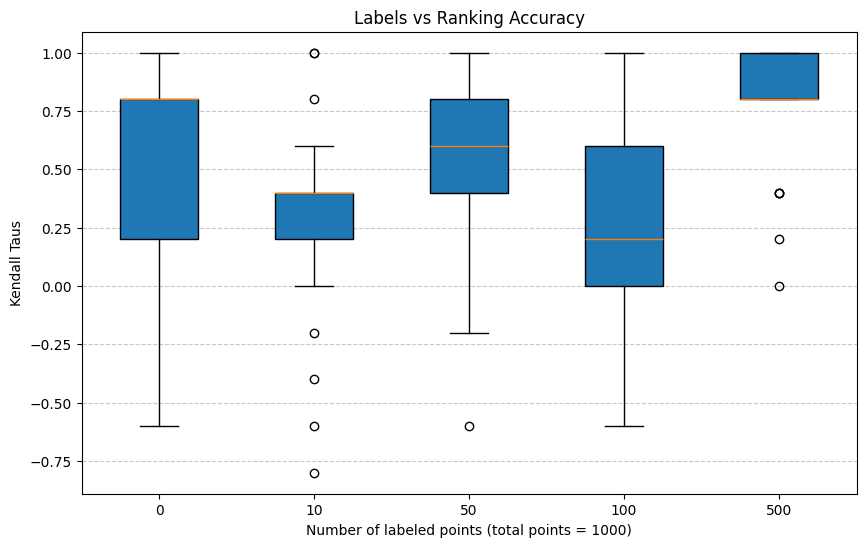

In [14]:
labels = ['0'] + [key for key in kendalls_labeled.keys()]
values = [kend_us[:25]] + list(kendalls_labeled.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.boxplot(values, vert=True, patch_artist=True, labels=labels)
plt.title("Labels vs Ranking Accuracy")
plt.xlabel("Number of labeled points (total points = 1000)")
plt.ylabel("Kendall Taus")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# len([kend_us] + values)

rankings, predictions_on_N, true_y = simulate_models_and_predictions(num_models=5, N=1000, num_features=5)
accs_only = [tup[1] for tup in rankings]

match_rates = []
for i in range(predictions_on_N.shape[1]):
    match_rate = np.mean(predictions_on_N[:, i] == true_y)
    match_rates.append(match_rate)

N=1000
label=0
indices = observed_indices = torch.randperm(N)[:label]
# print(indices)

mask = [False for i in range(N)]
for index in indices:
    mask[index] = True


pyro.clear_param_store()
logging.getLogger("pyro").setLevel(logging.DEBUG)
nuts_kernel = NUTS(corrected_dawid_skene_model_with_observed, jit_compile=True, ignore_jit_warnings=True)
mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=500)

observed_y = torch.full((N,), -1, dtype=torch.int64)
observed_y[indices] = torch.tensor(true_y[indices])
mcmc.run(torch.tensor(predictions_on_N), observed_y, torch.tensor(mask))

posterior_samples_corrected = mcmc.get_samples()

theta = posterior_samples_corrected["theta"]
pi = posterior_samples_corrected["pi"]
# 1. & 3. Take max values from rows 0 and 1 respectively
max_row_0 = torch.max(theta[:,:,0,:], dim=2)[0]  # Shape: (500, 5)
max_row_1 = torch.max(theta[:,:,1,:], dim=2)[0]  # Shape: (500, 5)

# 2. & 4. Multiply with pi values
result_row_0 = max_row_0 * pi[:,0].unsqueeze(1)  # Shape: (500, 5)
result_row_1 = max_row_1 * pi[:,1].unsqueeze(1)  # Shape: (500, 5)

# 5. Sum the results
result = result_row_0 + result_row_1  # Shape: (500, 5)

6